# Final Project for Adaptive Decision Making
### Modeling Behavioral Data from Attention Decay Study with Single-boundary DDM
Group Members: Oscar, Emilio, and William

# Background
![Experiment Poster](https://camo.githubusercontent.com/4b510f96fe6b30569dc991d36cbfd7d767f9c85d/68747470733a2f2f696d6167652e6962622e636f2f65486b7141792f506f737465722e6a7067)

## What we knew about the Data
 
+ Across all participants, reaction times went up in the end period when compared to the initial period. (statistically signficant). i.e., everyone slowed down. 
+ **Stable** participants got more slow than **Variable**
+ **Infrequent** participants got more slow than **Frequent**

It was hypothesized that this is due to a decay in attention. Furthermore, the results of this experiment, pointed to the attention decay being due to task monotony, or boredom. 

# Problem 

In DDM research with human subjects, datapoints are sometimes taken from time periods which are 20 minutes or longer [Driver distraction study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4032619/pdf/nihms545822.pdf). 


+ **Research Question 1 ** Can we fit a single-boundary DDM to our empirical Reaction Time (RT) distribution?
+ **Research Question 2 ** Can we Modify the DDM to account for demonstrated attention decay in our empirical data? Will this produce a better fit? 
+ **Research Question 3 ** What can DDM Modeling tell us about the cognitive process of perceptual decision making?


# Modeling

#### Single decision boundary DDM
This was created by basically ignoring the lower or "no" decision boundary. The modifications to the general DDM algorithm are such:
- If the evidence ever falls below zStart, set the evidence to zStart
- Remove the loop breaking logic for a "no" decision

#### Decay parameter and decay acceleration
We wanted to build in the parameters for attention decay. The intuition is that people will lose focus and pay less attention. The amount of attention that they give to the task will lessen over time such that the speed of evidence gathering is decreasing as the number of trials increases. 
We decided to go with a simple decay model:
- Each trial has an associated decay such that at each step of the evidence gathering, the decision to save a drowning face will get dragged towards "no decision made" by the decay
- After each trial, the amount of decay increases by the decay acceleration

#### Simulating the DDM
Once these models were made, we created algorithms for calculating the chi-square formulas for the dataframe that we had from the behavioral study and the dataframe that we generated with these DDM simulations.

From there we can simulate the DDM and compare it against the behavioral dataframes and tune the parameters to minimize the chi-square and maximize the p-value.

### Do all of our main imports first

In [1]:
%cd ..

/Users/EVVData/Desktop/CMU/Classes/8 - 7th Semester/85-435 Neural and Cognive Models of Adaptive Decisions/Final Project/FinalProjModel


In [2]:
from __future__ import division
from ADMCode import visualize as vis

import numpy as np
import pandas as pd
import numba as nb

from numba.decorators import jit
from numpy.random import random_sample
from numba import float64, int64, vectorize, boolean

from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline

Trial = 0

### Create a single decision barrier DDM

In [3]:
@jit(nb.typeof((1.0, 1.0))(float64[:], float64[:], float64[:]), nopython=True)
def sim_ddm(parameters, rProb, trace):

    # extract parameters
    a, tr, v, z, si, dx, dt = parameters

    # convert drift-rate into a probability,
    # & scale by sigma (si) and timestep (dt)
    # if v > 0, then 0.5 < vProb < 1.0
    # if v < 0, then 0.0 < vProb < 0.5
    vProb = .5 * (1 + (v * np.sqrt(dt))/si)

    # define starting point with respect to boundary height
    zStart = z * a

    #initialize evidence variable at zStart
    evidence = zStart
    trace[0] = evidence

    # define deadline (max time allowed for accumulation)
    deadline = trace.size

    for nsteps in range(1, deadline):
        # sample a random probability (r) and compare w/ vProb
        if rProb[nsteps] < vProb:
            # if r < vProb, step evidence up (towards a)
            evidence += dx
        else:
            # if r > vProb, step evidence down (towards 0)
            evidence -= dx

        if evidence < zStart:
            evidence = zStart
            
        # store new value of evidence at current timestep
        trace[nsteps] = evidence
            
        if evidence >= a:
            # calculate RT (in milliseconds)
            rt = tr + (nsteps * dt)
            # set choice to 1.0 (upper bound)
            choice = 1.0

            # terminate simulation, return rt & choice
            return rt, choice

    # return -1.0 for rt and choice so we can filter out
    # trials where evidence never crossed 0 or a
    return -1.0, -1.0

### Background code for running DDM and generating dataframes

In [4]:
def gen_ddm_storage_objects(parameters, ntrials=200, deadline=1.5):
    dt = parameters[-1]
    ntime = np.int(np.floor(deadline / dt))
    data = np.zeros((ntrials, 2))
    rProb = random_sample((ntrials, ntime))
    traces = np.zeros_like(rProb)
    return data, rProb, traces

def clean_output(data, traces, deadline=1.2, stimulus=None):
    df = pd.DataFrame(data, columns=['rt', 'choice'])
    df.insert(0, 'trial', np.arange(1, 1+df.shape[0]))
    df = df[(df.rt>0)&(df.rt<deadline)]
    traces = traces[df.index.values, :]
    df = df.reset_index(drop=True)
    return df, traces

@jit((float64[:], float64[:,:], float64[:,:], float64[:,:]), nopython=True)
def _sim_ddm_trials_(parameters, data, rProb, traces):
    ntrials = data.shape[0]
    for t in range(ntrials):
        data[t, :] = sim_ddm(parameters, rProb[t], traces[t])

def sim_ddm_trials(parameters, ntrials=500, deadline=1.5, decay=False):
    data, rProb, traces = gen_ddm_storage_objects(parameters, ntrials, deadline)
    _sim_ddm_trials_(parameters, data, rProb, traces)
    df, traces = clean_output(data, traces, deadline=deadline)
    return df, traces

### Initialize our parameters
We can begin with a regular DDM (with one boundary) and tweak with the parameters or potentially add more parameters to get this best fit to the behavioral data that we have

In [5]:
a = .09 # boundary height
v = .25 # strong drift-rate
tr = .15 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .1 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 2 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = 100 # number of trials to simulate



parameters = np.array([a, tr, v, z, si, dx, dt])

In [6]:
df, traces = sim_ddm_trials(parameters, ntrials, deadline)
df.head(10)

,trial,rt,choice
0,1,0.307,1.0
1,2,0.318,1.0
2,3,0.536,1.0
3,4,0.437,1.0
4,5,0.504,1.0
5,6,0.343,1.0
6,7,0.306,1.0
7,8,0.428,1.0
8,9,0.237,1.0
9,10,0.322,1.0


In [7]:
accuracy = df.choice.mean()
corRT = df[df.choice==1].rt.mean()
y,x = df.shape
count = 0 
print(y)


while count <y:

    df["rt"][count] =  (df["rt"][count])
    
    count+=1


print("RT (cor) = {:.0f} ms".format(corRT/dt))
print("Accuracy = {:.0f}%".format(accuracy*100))

100
RT (cor) = 448 ms
Accuracy = 100%


### Visualization of single barrier DDM

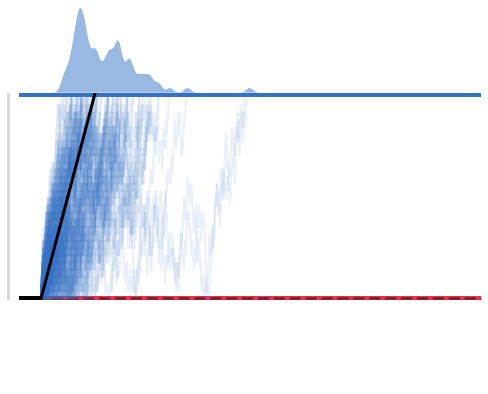

In [8]:
ax = vis.plot_this_sims(df, parameters,traces = traces, plot_v=True)

### Create a single decision barrier DDM with attention decay

In [9]:
@jit(nb.typeof((1.0, 1.0))(float64[:], float64[:], float64[:]), nopython=True)
def sim_decay_ddm(parameters, rProb, trace):
    # extract parameters
    a, tr, v, z, si, dx, dt, decay, decay_acceleration = parameters

    # convert drift-rate into a probability,
    # & scale by sigma (si) and timestep (dt)
    # if v > 0, then 0.5 < vProb < 1.0
    # if v < 0, then 0.0 < vProb < 0.5
    vProb = .5 * (1 + (v * np.sqrt(dt))/si)

    # define starting point with respect to boundary height
    zStart = z * a

    #initialize evidence variable at zStart
    evidence = zStart
    trace[0] = evidence

    # define deadline (max time allowed for accumulation)
    deadline = trace.size

    for nsteps in range(1, deadline):
        # sample a random probability (r) and compare w/ vProb
        if rProb[nsteps] < vProb:
            # if r < vProb, step evidence up (towards a)
            evidence += dx
        else:
            # if r > vProb, step evidence down (towards 0)
            evidence -= dx

        # always add in decay parameter
        evidence -= (decay + decay_acceleration * Trial)
            
        if evidence < zStart:
            evidence = zStart
            
        # store new value of evidence at current timestep
        trace[nsteps] = evidence
            
        if evidence >= a:
            # calculate RT (in milliseconds)
            rt = tr + (nsteps * dt)
            # set choice to 1.0 (upper bound)
            choice = 1.0

            # terminate simulation, return rt & choice
            return rt, choice

    # return -1.0 for rt and choice so we can filter out
    # trials where evidence never crossed 0 or a
    return -1.0, -1.0

In [10]:
df.head(10)

,trial,rt,choice
0,1,0.307,1.0
1,2,0.318,1.0
2,3,0.536,1.0
3,4,0.437,1.0
4,5,0.504,1.0
5,6,0.343,1.0
6,7,0.306,1.0
7,8,0.428,1.0
8,9,0.237,1.0
9,10,0.322,1.0


### Background code for running decay DDM and generating dataframes

In [11]:
@jit((float64[:], float64[:,:], float64[:,:], float64[:,:]), nopython=True)
def _sim_decay_ddm_trials_(parameters, data, rProb, traces):
    ntrials = data.shape[0]
    for t in range(ntrials):
        Trial = t
        data[t, :] = sim_decay_ddm(parameters, rProb[t], traces[t])

def sim_decay_ddm_trials(parameters, ntrials=500, deadline=1.5, decay=False):
    data, rProb, traces = gen_ddm_storage_objects(parameters, ntrials, deadline)
    _sim_decay_ddm_trials_(parameters, data, rProb, traces)
    df, traces = clean_output(data, traces, deadline=deadline)
    return df, traces

In [12]:
a = .3 # boundary height
v = .40 # strong drift-rate
tr = 0 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .1 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 5 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = 1000 # number of trials to simulate
decay = 0.000005
decay_acceleration = 0.00001


parameters_decay = np.array([a, tr, v, z, si, dx, dt, decay, decay_acceleration])


In [13]:
decayDf, traces = sim_decay_ddm_trials(parameters_decay, ntrials, deadline)
meanRT = decayDf.rt.mean()

stdDevRT = decayDf.rt.std()

print("RT (average) = {:.0f} ms".format(meanRT/dt))
print('stdDev = {:.0f} ms'.format(stdDevRT/dt))

RT (average) = 738 ms
stdDev = 200 ms


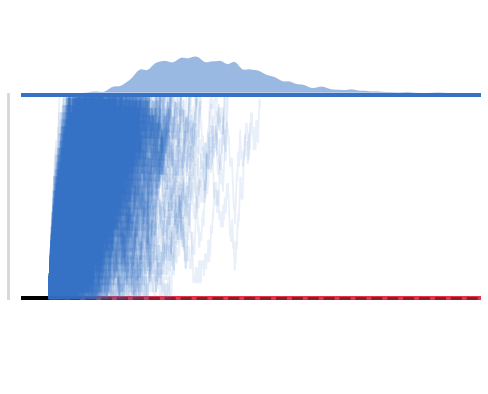

In [14]:
bx = vis.plot_this_sims(decayDf, parameters,traces = traces, plot_v=False)

## Our Approach to Model Accuracy Estimation 
Now that we've created a single boundary DDM capable of producing simulated Reaction Time distribution, we want to begin manipulating its parameters to fit it to our experimental data. In order to do that in a principled way, however, we need a way of measuring if a particular set of parameters produces a better fit on the experimental data than another set of parameters. For this we will use a Chi Square 'goodness of fit' test. 

#### TODO: $$Formula For Chi Square Goes Here$$ 

The goal for our model is to minimize the value of the Chi Square, as it represents the likelihood that the distribution produced by the model is the same distribution from the experimental data.

### Chi Square to Calculate Goodnes of Fit
At a conceptual level, we are comparing how closely the observed (experimental) data matches the expected (simulation) data. We calculate the probability of any differences between the datasets being present, if they are indeed sampled from the same distribution. 

#### TODO: Visualization of Observed vs Expected distribution, can use lecture slides



+ **Note** here, that because we are using a single output of the model simulation, a model that inherently has a high variance between Simualtion instances can have significantly different $\chi^2 $ value depending on which instance we use calculate this statistic. As such, averaging the distributions between simulations of such a model increases reliability. 

### 'Bucketing' the data
For us to be able to calculate the $\chi^2$ fit we need to choose RT intervals within which to 'bucket' data points. Intuitively, the more fine-grained the buckets, the snugger the fit. But there is a catch. For this calculation to have statistical validity we must have at least 5 data points within each bucket. While this is not a problem for simulation data, it is a limitation for our experimental data since we only have so many trials. 

This is a key constraint that has downstream effects on what we choose to model and what comparisons we draw. Particularly, individual subject modeling now becomes a challnge, as we only have 47 data points for the entire experiment (3 for the pre-test period, 41 for the experimental period, and 3 for the post-test period). This is mostly due to flaws in the experimental design, and of course, the researchers have no clue that the data was going to be modeled in this way. 

#### TODO: Present our RT intervals and the rationale/process for arriving at them 



### The algorithm for calculating the goodness of fit
Special thanks to Wikipedia, Khan Academy and Tim and Kyle for the surprinsingly informative vizualization of the $\chi^2$ estimation on the DDM lecture slides. 

1. Define the buckets for your RT intervals. 
2. Collect your data points into the buckets. Do this for the experimental data and the simulated data (using the same intervals for both data sets).  
3. Count the Data points inside the intervals to make sure there is more than 5 in each bucket (Large Counts condition)
4. For each interval calculate $(observed counts - expected counts)/expected counts$, and then sum them all to calculate the Chi Square of your model. 
$$ \chi^s = SumFormulaHere $$
5. Get the degrees of freedom of this Chi Square distribution by subtracting one from your number of buckets. 
6. Compare your Chi Square against the critical Chi Square values for different values of $\alpha$. They represent the likelihood that your simulated and observed data come from the same distribution. 
    * There is a $\alpha$ percent chance that if the two datasets come from the same distribution, their differences would be what they are or more extreme



## Setting up goodness of fit calculation

### Importing and Formatting experimental data

In [15]:
import pandas as pd
dataPath = "data/RTData.csv"
data = pd.read_csv(dataPath, header = 0)
data = data.dropna()

dataWhole = data[data.isFreq == 1]
dataisV = dataWhole[dataWhole.isVar==1]
dataisNV = dataWhole[dataWhole.isVar==0]
dataisInit = data[data.timePeriod == 'Initial']
dataisEnd = data[data.timePeriod == 'End']

def changeD(rData): 
    rRT = "clickDelay"
    rt = "rt"
    trial = []
    newRT = []
    newCh = []
    dShape,garb = rData.shape
    trial = [i for i in range(dShape)]
    newRT = list(rData[rRT])

    newCh = [1 for i in range(dShape)]
    newDf = {"trial":trial,"rt":newRT,"choice":newCh}
    return pd.DataFrame(data = newDf)
dataAll,dataVar,dataNVar,dataInit,dataEnd = changeD(dataWhole),changeD(dataisV),changeD(dataisNV),changeD(dataisInit),changeD(dataisEnd)

#add identifiers 
dataAll['id'] = 'All'
dataVar['id'] = 'Var'
dataNVar['id'] = 'NVar'

### Defining the Buckets
Our first thought to define our 'buckets' was by setting them to be the width of one standard deviation, with two 'catch all' buckets for the distribution tails. After some testing, these proved to be a bit too wide so we set them to half of a standard deviation. 

We experimented by using the standard error $\sigma/\sqrt{N}$, but it proved too small. 

After gathering the RT counts within the buckets we realized we had to collapse the initial buckets into one because the contained too few counts. As such they would violate the large counts assumption of the Chi Square model and ruin our **statistical validity**. This is due to the experimental data having a rightward skew. 

#### Our initial buckets
Experimental buckets:
+ All data buckets =  [0, 0, 0, 16, 108, 70, 69, 44, 27, 20, 15, 16, 31]
+ Variable condition buckets =  [0, 0, 0, 22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
+ Sable condition buckets =  [0, 0, 0, 2, 47, 43, 30, 18, 10, 8, 3, 6, 16]

We need at least 5 data points in each bucket. 

In [77]:
import math

def stdDev(mean,L):
    Sum = 0
    for i in L: 
        Sum+=math.pow((i-mean),2)
    return math.sqrt((Sum/len(L)))


def bucketer(mean,stdD,n):
    conMax = 3 #confidence rating 
    n = math.sqrt(n)
    bucket = []
    low = -1*conMax
    high = conMax+1 
    for i in [j for j in range(low,high)]:
        term = mean + i*(stdD/n)
        bucket.append(term)
    return bucket

def sampleBasedBucketer(mean, stdD):
    distance = 6 # 2 std devs, since it will be halved below
    bounds = []
    for i in range(-distance, distance):
        term = mean + i * (stdD/3)
        bounds.append(term)    
    return bounds


def getSampleBounds(panDf):
    mean = panDf.rt.mean()
    stdDev = panDf.rt.std()
    print("sample Mean = {:.3f} s".format(mean))
    print("sample Std Dev = {:.3f} s".format(stdDev))
    return sampleBasedBucketer(mean, stdDev)
           
def getStats(panDf): 
    y,x = panDf.shape
    Sum = 0
    count =0
    new = []
    while count<y:
        ind = panDf["rt"][count]
        Sum+= ind
        new+=[ind]
        count+=1
    mean = Sum/count
    std = stdDev(mean,new)
    n = len(new)
    buck = bucketer(mean,std,n)
    return mean,std,buck

testM,testD,testB = getStats(decayDf)

sampleBounds = getSampleBounds(decayDf)

#print('std Error buckets')
#for bound in testB:
#    print(bound)

#print('sample std Dev buckets')
#for bound in sampleBounds:
#    print(bound)
    
print("simulated Mean = {:.3f} s".format(testM))
print("simulated Std Dev = {:.3f} s".format(testD))

simulated Mean = 0.738 s
simulated Std Dev = 0.200 s


#### Count the buckets into an histogram-like array.

In [78]:
def isInBounds(lower, upper, value):
    return lower <= value and value <= upper

def getBuckets(bounds, dataframe):
    buckets = [0] * (len(bounds) + 1) 
    bounds.sort()
    boundsList = [] # [(lower1, upper1), (lower2, upper2) ...]
    for i,bound in enumerate(bounds):
        if i == 0:
            boundsList.append((0, bound))
        else:
            boundsList.append((bounds[i-1], bound))
        #add right tail end bucket
        if i == len(bounds) - 1:
            boundsList.append((bound, 100)) #100 is a catchAll 
            
    #print(dataframe.shape)
    for i,(lower, upper) in enumerate(boundsList):
        for rt in dataframe.rt.values:
            if isInBounds(lower, upper, rt):
                buckets[i] += 1
    return buckets

obsvMean,obsvDev,obsvBuck = getStats(dataAll)

sampleObsvBuck = getSampleBounds(dataAll)

simBucketCount = getBuckets(testB, decayDf)
obsvBucketCount = getBuckets(obsvBuck, dataAll)
obsvSampleBucketCount = getBuckets(sampleObsvBuck, dataAll)
simSampleBucketCount = getBuckets(sampleBounds, decayDf)



#print("simulated buckets: \n", simBucketCount)
print("simulated buckets sample based: \n", simSampleBucketCount)


print("\n All data experimental buckets: \n", obsvBucketCount)
print("All experimental  buckets sample based: \n", obsvSampleBucketCount)

#using sample based from now on

print("\nExperimental buckets:")
allDataBuckets = getBuckets(getSampleBounds(dataAll), dataAll)
varDataBuckets = getBuckets(getSampleBounds(dataVar), dataVar)
staDataBuckets = getBuckets(getSampleBounds(dataNVar), dataNVar)
print("All data buckets = ", allDataBuckets)
print("Variable condition buckets = ", getBuckets(getSampleBounds(dataVar), dataVar))
print("Sable condition buckets = ", getBuckets(getSampleBounds(dataNVar), dataNVar))

simulated buckets sample based: 
 [4, 15, 46, 95, 118, 137, 127, 112, 106, 85, 56, 39, 60]

 All data experimental buckets: 
 [238, 7, 10, 8, 9, 11, 6, 127]
All experimental  buckets sample based: 
 [0, 0, 0, 16, 108, 70, 69, 44, 27, 20, 15, 16, 31]

Experimental buckets:
All data buckets =  [0, 0, 0, 16, 108, 70, 69, 44, 27, 20, 15, 16, 31]
Variable condition buckets =  [0, 0, 0, 22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
Sable condition buckets =  [0, 0, 0, 2, 47, 43, 30, 18, 10, 8, 3, 6, 16]


#### Calculate Chi Square
while making sure to not violete the Large Counts rule

In [79]:
## calculate Chi squares
import scipy
from scipy import stats

def collapseUpToFive(L):
    firstCount = L[0]
    i = 1
    while firstCount <= 5:
        firstCount += L[i]
        i += 1
    return i - 1

#print(collapseUpToFive([0, 0, 0, 22, 54, 33, 31, 30, 14, 9, 12, 8, 20]))
#print(collapseUpToFive([0, 0, 0, 2, 47, 43, 30, 18, 10, 8, 3, 6, 16]))


def getChiSquare(observedDf, expectedDf):
    #get ObservedBounds
    bounds = getSampleBounds(observedDf)
    # get buckets for both using observedBounds
    observedBuckets = getBuckets(bounds, observedDf)
    truncator = collapseUpToFive(observedBuckets)
    adjustedBounds = bounds[truncator:]
    observedBuckets = getBuckets(adjustedBounds, observedDf)
    expectedBuckets = getBuckets(adjustedBounds, expectedDf)
    
    assert(len(observedBuckets) == len(expectedBuckets))
    
    
    
    observed_values = scipy.array(observedBuckets)
    expected_values = scipy.array(expectedBuckets)
    chiSquare, pValue = scipy.stats.chisquare(observed_values, f_exp=expected_values)
    print("observed buckets =", observedBuckets)
    print("expected buckets = ", expectedBuckets)
    print("chi Square = {:3f}".format(chiSquare))
    print("pvalue = {:3f}".format(pValue))
    return chiSquare, pValue 

#test chi square:
getChiSquare(dataVar, dataVar) 




observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
chi Square = 0.000000
pvalue = 1.000000


(0.0, 1.0)

### Vizualize the data to build intuition

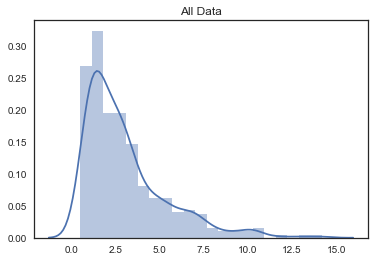

In [80]:
#plotting the raw Data 
allDataAx = sns.distplot(dataAll.rt.values).set_title('All Data')

#sample Mean = 3.026 s
#sample Std Dev = 2.304 s
#adj bounds =  [0.7220, 1.4900, 2.2581, 3.02624, 3.7943, 4.5623, 5.330, 6.09854, 6.8666]

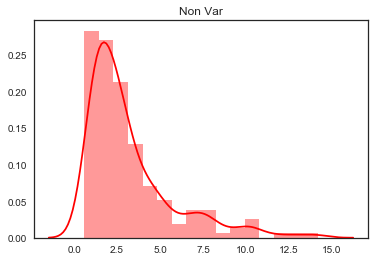

In [81]:
# Non Variable Statistics
#sample Mean = 3.200 s
#sample Std Dev = 2.540 s
#adj bounds (sec) = , 1.507, 2.354, 3.200, 4.047, 4.893, 5.740, 6.586, 7.433

staDataAx = sns.distplot(dataNVar.rt.values, color='r').set_title('Non Var')

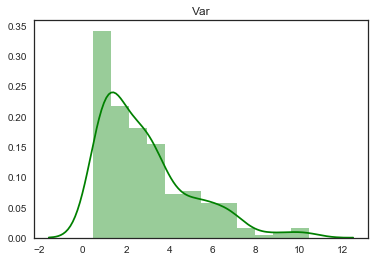

In [82]:
# Variable Statistics
#sample Mean = 2.890 s
#sample Std Dev = 2.096 s
#adj bounds (sec) =  0.793, 1.492, 2.191, 2.890, 3.588, 4.287, 4.986, 5.685, 6.384

varDataAx = sns.distplot(dataVar.rt.values, color='g').set_title('Var')

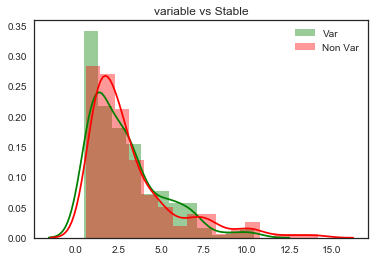

In [83]:
#plotting the raw Data for var and sta
varDataAx = sns.distplot(dataVar.rt.values, color='g', label='Var')
staDataAx = sns.distplot(dataNVar.rt.values, color='r', label='Non Var')
legend, title = plt.legend(), plt.title('variable vs Stable')

## Parameter Estimation

#### Simple Single-Bound DDM - Variable

In [138]:
a = .5 # boundary height
v = .025 # strong drift-rate
tr = .15 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .3 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 15 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = dataVar.shape[0] # number of trials to simulate



parameters = np.array([a, tr, v, z, si, dx, dt])

simVarDf, traces = sim_ddm_trials(parameters, ntrials, deadline)
cs, p = getChiSquare(dataVar, simVarDf)

Sum = 0
nTests = 100
for test in range(nTests):
    meanRT = simVarDf.rt.mean()
    stdDevRT = simVarDf.rt.std()

    #print("RT (average) = {:.0f} ms".format(meanRT/dt))
    #print('stdDev = {:.0f} ms'.format(stdDevRT/dt))
    simVarDf, traces = sim_ddm_trials(parameters, ntrials, deadline)
    cs,p = getChiSquare(dataVar, simVarDf)
    print()
    Sum += p
print("Mean p-value:", (Sum/nTests))

# nTests = 100
# FIXED tr = .15 # nondecision time (in seconds)
# FIXED a = .5 # boundary height
# FIXED deadline = 10


# v = .025 # strong drift-rate
# tr = .15 # nondecision time (in seconds)
# si = .3 # sigma (noise scalar)


#1. Mean p-value: 0.04289879858947255
#1. Mean p-value: 0.0676090509147776
#2. Mean p-value: 0.04599537788686006

# nTests = 100

# v = .025 # strong drift-rate
# tr = .15 # nondecision time (in seconds)
# si = .28 # sigma (noise scalar)
# 1. Mean p-value: 0.05314518032085878
# 2. Mean p-value: 0.051142024514737316
# 3. Mean p-value: 0.07103316323093263
# 4. Mean p-value: 0.03772700016880065
# 5. Mean p-value: 0.037529471785083694
# 6. Mean p-value: 0.057870262793050936
# 7. Mean p-value: 0.0481221591922852

# 8. Mean p-value: 0.0441032258938509


# nTests = 100

# v = .025 # strong drift-rate
# tr = .15 # nondecision time (in seconds)
# si = .3 # sigma (noise scalar)
# 1. Mean p-value: 0.04379184927676111
# 2. Mean p-value: 0.03465451399792911
# 3. Mean p-value: 0.05698895931969633
# 4. Mean p-value: 0.03247399811286513
# 5. Mean p-value: 0.047873108893434956
# 6. Mean p-value: 0.041134634470448364
# 7. Mean p-value: 0.039562699312054764


# v = .024 # strong drift-rate
# tr = .15 # nondecision time (in seconds)
# si = .3 # sigma (noise scalar)
# 1. Mean p-value: 0.03120281840494127
# 2. Mean p-value: 0.05139383123029375
# 3. Mean p-value: 0.05801531815819709
# 4. Mean p-value: 0.03451624951859156
# 5. Mean p-value: 0.03451624951859156
# 6. Mean p-value: 0.053182309786095484
# 7. Mean p-value: 0.04849856561756372


### FINAL #### 
# a = .5  boundary height - FIXED
# **v = .025  drift-rate
# tr = .15  nondecision time (in seconds) - FIXED
# z = 0  starting point - FIXED

# dt = .001  time step - FIXED
# si = .3  sigma (noise scalar) 
# dx = si * np.sqrt(dt)  evidence step - FIXED from sigma
# deadline = 15 # max decision time, based on experimental Data -- CHANGED FROM 10 ABOVE
# ntime = np.int(np.floor(deadline / dt))  time limit for decision
# ntrials = dataVar.shape[0] - based on amount of experimental data points

#1. Mean p-value: 0.06652209493243914
#2. Mean p-value: 0.06097599451354407
#3. Mean p-value: 0.07954134821123347
#4. Mean p-value: 0.0706889817201901
#5. Mean p-value: 0.0768552980487135
#6. Mean p-value: 0.06516668907165654
#7. Mean p-value: 0.07362199542060469




#varx = vis.plot_this_sims(df, parameters,traces = traces, plot_v=True)

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [19, 50, 50, 32, 23, 16, 11, 6, 9, 16]
chi Square = 16.460116
pvalue = 0.057873
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [13, 65, 37, 30, 29, 11, 14, 7, 7, 19]
chi Square = 14.963370
pvalue = 0.091947

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [18, 54, 48, 36, 24, 19, 14, 6, 7, 6]
chi Square = 49.681861
pvalue = 0.000000

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [25, 56, 42, 31, 24, 13, 14, 7, 5, 16]
chi Square = 12.094066
pvalue = 0.208058

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [15, 63, 44, 25, 25, 14, 14, 11, 4, 18]
chi Square = 15.841227
pvalue = 0.070272

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [16, 60, 33, 41, 20, 20, 9, 7, 6, 21]
chi Square = 16.374739
pvalue = 0.059457

observed buckets = [22, 54, 33, 31, 30, 14, 9, 1

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [17, 54, 44, 32, 26, 21, 15, 10, 4, 10]
chi Square = 24.000556
pvalue = 0.004300

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [22, 58, 48, 36, 22, 15, 9, 7, 6, 10]
chi Square = 22.871659
pvalue = 0.006491

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [14, 56, 38, 24, 25, 18, 22, 11, 10, 15]
chi Square = 19.070701
pvalue = 0.024598

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [21, 54, 38, 29, 21, 18, 15, 13, 9, 15]
chi Square = 9.844177
pvalue = 0.363247

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [26, 52, 47, 40, 13, 15, 15, 6, 7, 12]
chi Square = 43.061147
pvalue = 0.000002

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [21, 57, 39, 31, 19, 22, 13, 9, 5, 17]
chi Square = 14.966284
pvalue = 0.091866

observed buckets = [22, 54, 33, 31, 30, 14, 

#### Decay Single-Bound DDM - Variable

In [ ]:
a = .5 # boundary height
v = .025 # strong drift-rate
tr = .15 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .3 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 15 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = dataVar.shape[0] # number of trials to simulate
decay = 0.000001
decay_acceleration = 0.000015


parameters_decay = np.array([a, tr, v, z, si, dx, dt, decay, decay_acceleration])

simDecayVarDf, traces = sim_decay_ddm_trials(parameters_decay, ntrials, deadline)
cs, p = getChiSquare(dataVar, simDecayVarDf)

Sum = 0
nTests = 10
for test in range(nTests):
    meanRT = simDecayVarDf.rt.mean()
    stdDevRT = simDecayVarDf.rt.std()

    print("RT (average) = {:.0f} ms".format(meanRT/dt))
    print('stdDev = {:.0f} ms'.format(stdDevRT/dt))
    simDecayVarDf, traces = sim_decay_ddm_trials(parameters_decay, ntrials, deadline)
    cs,p = getChiSquare(dataVar, simDecayVarDf)
    print()
    Sum += p
print("Mean p-value:", (Sum/nTests))


# decay = 0.000005
# decay_acceleration = 0.00001
# trials = 5
# 1. Mean p-value: 0.10789689468421959
# 2. Mean p-value: 0.25862639131270226
# 3. Mean p-value: 0.045531923936901565
# 4. Mean p-value: 0.11921989664480119

# trials 10
# 5. Mean p-value: 0.07324391874445607


# decay = 0.000001
# decay_acceleration = 0.00001

# trials 5 
# Mean p-value: 0.045985276409831105
# Mean p-value: 0.05067196009896008


#trials 10
# decay = 0.000001
# decay_acceleration = 0.000015

# 1. Mean p-value: 0.07620314122733317
# 2. Mean p-value: 0.12799771248528222





#varx = vis.plot_this_sims(df, parameters,traces = traces, plot_v=True)

observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [14, 65, 46, 38, 16, 14, 12, 7, 4, 16]
chi Square = 32.967782
pvalue = 0.000135
RT (average) = 2693 ms
stdDev = 2162 ms
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [20, 55, 46, 31, 22, 22, 13, 11, 0, 13]
chi Square = inf
pvalue = 0.000000

RT (average) = 2672 ms
stdDev = 1925 ms
observed buckets = [22, 54, 33, 31, 30, 14, 9, 12, 8, 20]
expected buckets =  [19, 54, 39, 36, 25, 17, 13, 11, 9, 10]
chi Square = 15.053407
pvalue = 0.089479

RT (average) = 2693 ms
stdDev = 1787 ms


#### Simple Single-Bound DDM - Non Variable

In [150]:
a = .5 # boundary height
v = .01 # strong drift-rate
tr = .15 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .3 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 15 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = dataNVar.shape[0] # number of trials to simulate


parameters = np.array([a, tr, v, z, si, dx, dt])

simNVarDf, traces = sim_ddm_trials(parameters, ntrials, deadline)
cs, p = getChiSquare(dataNVar, simNVarDf)

Sum = 0

nTests = 100
for test in range(nTests):
    meanRT = simNVarDf.rt.mean()
    stdDevRT = simNVarDf.rt.std()

    print("RT (average) = {:.0f} ms".format(meanRT/dt))
    print('stdDev = {:.0f} ms'.format(stdDevRT/dt))
    simNVarDf, traces = sim_ddm_trials(parameters, ntrials, deadline)
    cs,p = getChiSquare(dataNVar, simNVarDf)
    print()
    Sum += p
print("Mean p-value:", (Sum/nTests))
# Fixed 

# Drift = 0.017
# tr = .18 
# si = .3 
# Mean p-value: 0.07955922843750889
# Mean p-value: 0.04469544177299441
# Mean p-value: 0.0953501165379997
# Mean p-value: 0.08569046664415454
# Mean p-value: 0.054801776272912134

# Drift 0.01
# tr = .18 
# si = .3 
# 1. Mean p-value: 0.08446343243450283
# 2. Mean p-value: 0.07625318993730766
# 3. Mean p-value: 0.08699134747557684
# 4. Mean p-value: 0.057566439004003926
# 5. Mean p-value: 0.07803593472715536

# Drift 0.01
# tr = .15 
# si = .3 
# 1. Mean p-value: 0.09369521700415415
# 2. Mean p-value: 0.07482890892314648
# 3. Mean p-value: 0.06469414553201597
# 4. Mean p-value: 0.10096277400531264
# 5. Mean p-value: 0.0722822691562873
# 6. Mean p-value: 0.08419955583630839
# 7. Mean p-value: 0.07907774097035729

# varx = vis.plot_this_sims(df, parameters,traces = traces, plot_v=True)

observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [58, 33, 31, 18, 15, 9, 7, 4, 8]
chi Square = 17.522605
pvalue = 0.025105
RT (average) = 2874 ms
stdDev = 2052 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [70, 38, 28, 12, 14, 10, 3, 4, 4]
chi Square = 48.643609
pvalue = 0.000000

RT (average) = 2523 ms
stdDev = 1766 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [49, 53, 31, 14, 11, 6, 5, 5, 9]
chi Square = 10.263928
pvalue = 0.246988

RT (average) = 2788 ms
stdDev = 2035 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [60, 47, 25, 24, 10, 5, 3, 4, 5]
chi Square = 31.857092
pvalue = 0.000099

RT (average) = 2547 ms
stdDev = 1716 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [58, 35, 28, 18, 6, 15, 6, 9, 8]
chi Square = 19.801314
pvalue = 0.011114

RT (average) = 2989 ms
stdDev = 2271 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expecte

observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [58, 42, 20, 20, 14, 12, 5, 2, 9]
chi Square = 23.340996
pvalue = 0.002953

RT (average) = 2866 ms
stdDev = 2080 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [52, 51, 23, 16, 18, 10, 8, 2, 3]
chi Square = 75.222303
pvalue = 0.000000

RT (average) = 2660 ms
stdDev = 1741 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [55, 42, 22, 21, 12, 13, 5, 5, 8]
chi Square = 15.272428
pvalue = 0.054060

RT (average) = 2887 ms
stdDev = 2045 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [50, 47, 25, 18, 14, 6, 5, 7, 9]
chi Square = 9.557251
pvalue = 0.297485

RT (average) = 2899 ms
stdDev = 2119 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [68, 36, 26, 15, 12, 8, 5, 8, 5]
chi Square = 33.718653
pvalue = 0.000046

RT (average) = 2683 ms
stdDev = 2018 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expec

observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [63, 39, 25, 19, 15, 5, 3, 3, 9]
chi Square = 16.485110
pvalue = 0.035940

RT (average) = 2725 ms
stdDev = 2193 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [72, 30, 24, 14, 13, 9, 10, 1, 10]
chi Square = 49.926832
pvalue = 0.000000

RT (average) = 2865 ms
stdDev = 2406 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [52, 43, 34, 18, 14, 5, 3, 5, 9]
chi Square = 9.230967
pvalue = 0.323188

RT (average) = 2920 ms
stdDev = 2285 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [50, 47, 27, 18, 14, 4, 8, 5, 9]
chi Square = 14.606060
pvalue = 0.067273

RT (average) = 2979 ms
stdDev = 2323 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [53, 38, 33, 25, 16, 4, 5, 3, 6]
chi Square = 29.909175
pvalue = 0.000219

RT (average) = 2766 ms
stdDev = 2059 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expect

#### Decay Single-Bound DDM - Non Variable

In [163]:
a = .5 # boundary height
v = .01 # strong drift-rate
tr = .18 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .3 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence step
deadline = 15 # max decision time
ntime = np.int(np.floor(deadline / dt)) # time limit for decision
ntrials = dataNVar.shape[0] # number of trials to simulate

decay = 0.000001
decay_acceleration = 0.00002


parameters_decay = np.array([a, tr, v, z, si, dx, dt, decay, decay_acceleration])

simDecayNVarDf, traces = sim_decay_ddm_trials(parameters_decay, ntrials, deadline)
cs, p = getChiSquare(dataNVar, simDecayNVarDf)

Sum = 0
nTests = 10
for test in range(nTests):
    meanRT = simDecayNVarDf.rt.mean()
    stdDevRT = simDecayNVarDf.rt.std()

    print("RT (average) = {:.0f} ms".format(meanRT/dt))
    print('stdDev = {:.0f} ms'.format(stdDevRT/dt))
    simDecayNVarDf, traces = sim_decay_ddm_trials(parameters_decay, ntrials, deadline)
    cs,p = getChiSquare(dataNVar, simDecayNVarDf)
    print()
    Sum += p
print("Mean p-value:", (Sum/nTests))

## FINAL ##
# 10 trials each
# v = .01 # strong drift-rate
# tr = .18 # nondecision time (in seconds)
# decay = 0.000001
# decay_acceleration = 0.00002
# si = .3 # sigma (noise scalar)

# 1. Mean p-value: 0.20730942811071448
# 2. Mean p-value: 0.18283875765394314
# 3. Mean p-value: 0.13448462934086006
# 4. Mean p-value: 0.1009178903067969
# 5. Mean p-value: 0.17723952746285532
# 6. Mean p-value: 0.03160564614040784
# 7. Mean p-value: 0.08935682628518307
# 8. Mean p-value: 0.17648480606770195
# 9. Mean p-value: 0.03953694678094247
# 10. Mean p-value: 0.1542554286588084


# varx = vis.plot_this_sims(df, parameters,traces = traces, plot_v=True)

observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [40, 43, 27, 32, 10, 11, 9, 4, 7]
chi Square = 25.872944
pvalue = 0.001104
RT (average) = 3087 ms
stdDev = 2015 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [56, 42, 27, 15, 14, 9, 5, 4, 11]
chi Square = 7.158838
pvalue = 0.519596

RT (average) = 2961 ms
stdDev = 2397 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [54, 35, 26, 16, 22, 12, 4, 5, 9]
chi Square = 16.930151
pvalue = 0.030845

RT (average) = 3036 ms
stdDev = 2193 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [52, 45, 24, 20, 17, 11, 9, 2, 3]
chi Square = 73.995834
pvalue = 0.000000

RT (average) = 2765 ms
stdDev = 1825 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expected buckets =  [50, 37, 35, 19, 15, 14, 3, 3, 7]
chi Square = 20.569414
pvalue = 0.008384

RT (average) = 2878 ms
stdDev = 1925 ms
observed buckets = [49, 43, 30, 18, 10, 8, 3, 6, 16]
expe

# TODO

+ Results section
+ Conclusion 
+ Write Background and Problem sections

# Results

## RQ 1 Can we fit a single-boundary DDM to our empirical Reaction Time (RT) distribution?
Kind of, at least at a chance greater than 5%. 

##### Fixed Parameters: 
+ a = 0.5 
+ tr = .15 
+ si = 0.3 
+ dt= .001 
+ deadline = 15 
+ ntrials = number of data points in variable condition 

### Variable
##### Fitted Parameters 
+ v = .025 

##### P Value Results, every line is an average of 100 trials

+ 1. Mean p-value: 0.06652209493243914
+ 2. Mean p-value: 0.06097599451354407
+ 3. Mean p-value: 0.07954134821123347
+ 4. Mean p-value: 0.0706889817201901
+ 5. Mean p-value: 0.0768552980487135
+ 6. Mean p-value: 0.06516668907165654
+ 7. Mean p-value: 0.07362199542060469

**Global Mean** = TODO

### Non Variable
##### Fitted Parameters 
+ v = .01
+ si = 0.3

##### P Value Results, every line is an average of 100 trials

+ 1. Mean p-value: 0.09369521700415415
+ 2. Mean p-value: 0.07482890892314648
+ 3. Mean p-value: 0.06469414553201597
+ 4. Mean p-value: 0.10096277400531264
+ 5. Mean p-value: 0.0722822691562873
+ 6. Mean p-value: 0.08419955583630839
+ 7. Mean p-value: 0.07907774097035729

**Global Mean** = TODO

### RQ 2 Can we Modify the DDM to account for demonstrated attention decay in our empirical data? Will this produce a better fit?
Modeling attention decay as a linearly increasing drop in drift rate produced better fits to the data for both our conditions. **Note that all parameters remain equal for their respective conditions**. Drift rate for Variable and Non Variable remained 0.25 and 0.1 respectively




# Conclusion

### RQ 3 What can DDM Modeling tell us about the cognitive process of perceptual decision making?


## Future Work 

### Lessons Learned
+ Exploration vs Exploitation: A lot of the methods we employed here were a mixture of our current understanding along with inferences made on methodology from DDM papers (most notably Ratcliff et al., 2013). We had several instances of discovering a different method which would have worked better had we known it beforehand. Like how to use seaborn to quickly vizualize data, and a research-informed way of defining the quantiles (dubbed buckets by us), and using them to get to 'expected' values. That said we haad time constraints so it was unclear when to move forward with limited expertise and when to seek out more knowledge (zone of proximal development). Also, you don't know most of what you don't know. 

### Plots for initial vs End data 

notice how the end distribution is shifted more towards the right

In [121]:
dataInit.rt.sem()

0.2447305640316554

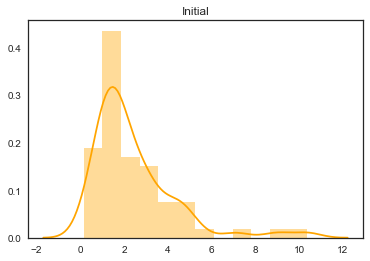

In [112]:
# mean 2.435 s
# std 1.927 s 
# error on mean 0.245 s
initialColor = '#FCC800'

initDataAx = sns.distplot(dataInit.rt.values, color='orange', label='Initial').set_title('Initial Period ')

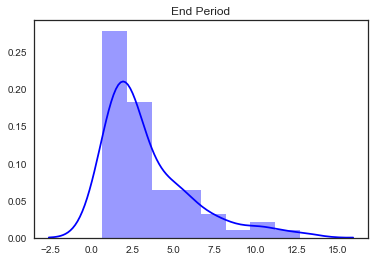

In [118]:
endColor = '#00479D'
# mean 3.378 s
# std 2.641 s
# error on mean 0.335 s
endDataAx = sns.distplot(dataEnd.rt.values, color='b', label='End').set_title('End Period')

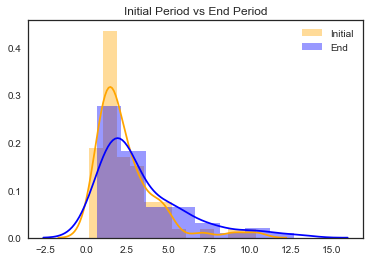

In [119]:
initDataAx = sns.distplot(dataInit.rt.values, color='orange', label='Initial')
endDataAx = sns.distplot(dataEnd.rt.values, color='b', label='End')
legend, title = plt.legend(), plt.title('Initial Period vs End Period')

# Works Cited
Ratcliff, Roger & Strayer, David. (2013). Modeling Simple Driving Tasks with a One-Boundary Diffusion Model. Psychonomic bulletin & review. 21. 10.3758/s13423-013-0541-x. 